In [1]:
%load_ext autoreload
%autoreload 2


/tmp/ipykernel_4846/252630401.py:84: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=10)
/tmp/ipykernel_4846/252630401.py:85: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)


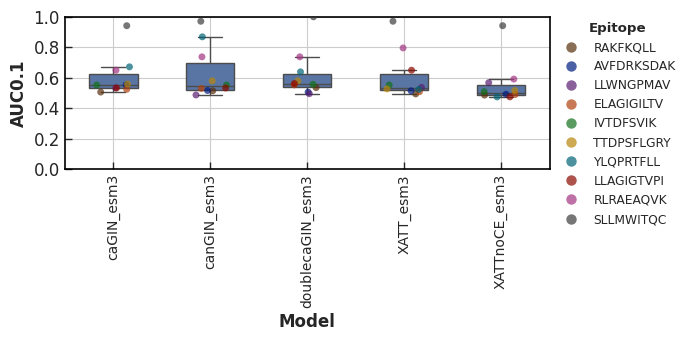

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import roc_auc_score
import seaborn as sns
import os



def assign_colors(categories, palette="deep"):
    unique_cats = sorted(set(categories))
    colors = sns.color_palette(palette, n_colors=len(unique_cats))
    return dict(zip(unique_cats, colors))


def auc_barplot(results_dirs, pattern="_raw_best.csv", save_dir=".", weighted_average=False):
    """
    Plots a barplot of AUC scores per peptide for each model using seaborn (mean and std).
    Args:
        results_dirs (list): List of directories containing results.
        pattern (str): File pattern to match.
        save_dir (str): Directory to save the plot.
        weighted_average (bool): If True, use weighted average for summary.
    """
    all_aucs = []
    for dir, model_name in results_dirs.items():
        for file in os.listdir(dir):
            if file.endswith(pattern):
                raw_results_path = os.path.join(dir, file)
                if not os.path.exists(raw_results_path):
                    print(f"File {raw_results_path} does not exist. Skipping.")
                    continue
                results_df = pd.read_csv(raw_results_path)

                unique_peptides = results_df['peptide'].unique()
                for peptide in unique_peptides:
                    peptide_data = results_df[results_df['peptide'] == peptide]

                    if len(peptide_data['labels'].unique()) < 2:
                        continue
                    auc = roc_auc_score(peptide_data['labels'], peptide_data['predictions'], max_fpr=0.1)
                    all_aucs.append({
                        'Model': model_name,
                        'Peptide': peptide,
                        'AUC': auc,
                        'Count': len(peptide_data)
                    })

    auc_df = pd.DataFrame(all_aucs)

    # --- Style ---
    sns.set_theme(context='paper', style='whitegrid')
    #sns.set_palette('deep')

    plt.figure(figsize=(7, 3.5))  # single-column figure (NeurIPS size)

    peptide_colors =  assign_colors(auc_df['Peptide'], palette='dark')
    
    # --- Boxplot ---
    ax = sns.boxplot(
        data=auc_df,
        x='Model',
        y='AUC',
        showfliers=False,
        width=0.5
    )

    # --- Overlay individual points as jitter plot ---
    sns.stripplot(
        data=auc_df,
        x='Model',
        y='AUC',
        hue='Peptide',
        dodge=False,
        palette=peptide_colors,
        alpha=0.7,
        size=5,
        jitter=0.18,
        ax=ax
    )

    ax.set_ylabel('AUC0.1', fontsize=12, weight='bold')
    ax.set_xlabel('Model', fontsize=12, weight='bold')
    ax.set_ylim(0, 1.0)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=10)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
    ax = plt.gca() 
    plt.rcParams["xtick.major.size"] = 50

    # increase linewidth of axes and make them black
    for spine in ax.spines.values():
        spine.set_linewidth(1.2)
        spine.set_color('black')

    ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0., frameon=False,
              title='Epitope', title_fontproperties={'weight':'bold'}, markerscale=1.5)
    ax.grid(True)
    plt.tick_params(axis='both', which='both', direction='in', bottom=True, left=True)
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, "auc_barplot.png"), dpi=300)
    plt.show()

# Example usage
results_dirs = {"../cagin_neg5_esm3_dp03": "caGIN_esm3",
                "../cangin_neg5_esm3_dp03": "canGIN_esm3",
                "../doublecagin_neg5_esm3_dp03": "doublecaGIN_esm3",
                "../developments/test_xatt/GIN_cn1_ce1_neg5_esm3_dp03": "GINXATT_esm3",
                "../developments/test_xatt/GIN_cn1_ce0_neg5_esm3_dp03": "GINXATTnoCE_esm3"
                }

auc_barplot(results_dirs, pattern="_raw_best.csv", save_dir=".", weighted_average=True)

/tmp/ipykernel_14025/372187677.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='mindist', y=pep_distances.index, data=pep_distances,
/tmp/ipykernel_14025/372187677.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)
/tmp/ipykernel_14025/372187677.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)


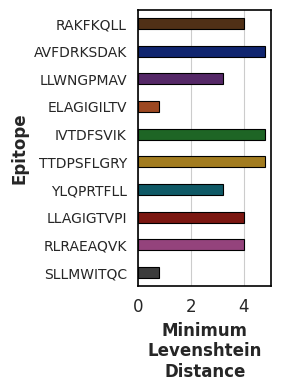

In [136]:
from Levenshtein import distance as levenshtein_distance
import numpy as np

def peptide_levenshtein(peptides, peptides_dataset):
   
    # Compute distances
    distances = {}
    for pep in peptides:
        update_pep_dataset = [ref for ref in peptides_dataset if ref != pep]
        distances[pep] = np.min([levenshtein_distance(pep, ref) for ref in update_pep_dataset])

    df = pd.DataFrame.from_dict(distances, orient='index', columns=['mindist'])
    return df

def distance_barplot(pep_distances):

    #pep_distances = pep_distances.sort_values(by='mindist')
    # --- Style ---
    sns.set_theme(context='paper', style='whitegrid')
    peptide_colors =  assign_colors(pep_distances.index, palette='dark')

    plt.figure(figsize=(2.9, 4))  # single-column figure (NeurIPS size)
    ax = sns.barplot(x='mindist', y=pep_distances.index, data=pep_distances, 
                     palette=peptide_colors, edgecolor='black', width=0.4)

    ax.set_xlabel('Minimum\nLevenshtein\nDistance', fontsize=12, weight='bold')
    ax.set_ylabel('Epitope', fontsize=12, weight='bold')
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
    ax = plt.gca() 
    plt.rcParams["xtick.major.size"] = 50

    # increase linewidth of axes and make them black
    for spine in ax.spines.values():
        spine.set_linewidth(1.2)
        spine.set_color('black')

    plt.tight_layout()
    plt.savefig("peptide_levenshtein_distance_barplot.png", dpi=300)
    plt.show()


summary = pd.read_csv("/home/samuel.assis/MatchImm/4_GNN/cagin_neg5_esm3_dp03/results_CrossAttentionGIN_20251026_summary.csv")
peptides = summary['peptide'].tolist()
dataset_af = pd.read_csv("/home/samuel.assis/MatchImm/3_StructPred/predictions/VDJdb/score_3/results/AF_vdjdb_score3_20251026.csv")
dataset_pdb = pd.read_csv("/home/samuel.assis/MatchImm/4_GNN/tcr3d_20251004_renamed.csv")

reference = dataset_af['peptide'].tolist() + dataset_pdb['epitope'].tolist()

df = peptide_levenshtein(peptides, reference)
distance_barplot(df)

/tmp/ipykernel_2439051/3325090125.py:40: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  ax = sns.barplot(
/tmp/ipykernel_2439051/3325090125.py:53: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=10)
/tmp/ipykernel_2439051/3325090125.py:54: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)


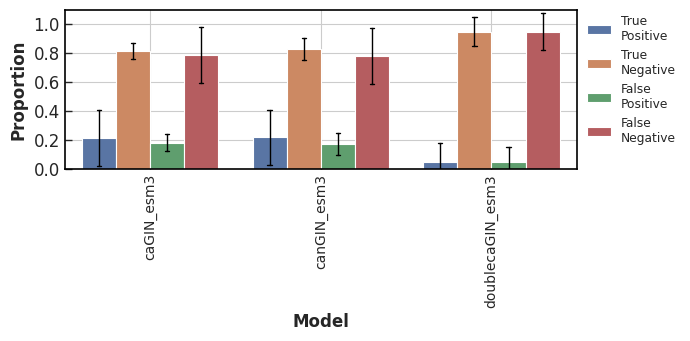

In [2]:
def confusion_barplot(results_dirs, pattern="_summary.csv", save_dir="."):
    """
    Plots a barplot of confusion matrix metrics (TP, TN, FP, FN) per peptide for each model using seaborn.
    Args:
        results_dirs (list): List of directories containing results.
        pattern (str): File pattern to match.
        save_dir (str): Directory to save the plot.
    """
    all_metrics = []
    for dir, model_name in results_dirs.items():
        for file in os.listdir(dir):
            if file.endswith(pattern):
                raw_results_path = os.path.join(dir, file)
                if not os.path.exists(raw_results_path):
                    print(f"File {raw_results_path} does not exist. Skipping.")
                    continue
                results_df = pd.read_csv(raw_results_path)
                for _, row in results_df.iterrows():
                    all_metrics.append({
                        'Model': model_name,
                        'Peptide': row['peptide'],
                        'True\nPositive': row['tp'] / (row['tp'] + row['fn']),
                        'True\nNegative': row['tn'] / (row['tn'] + row['fp']),
                        'False\nPositive': row['fp'] / (row['fp'] + row['tn']),
                        'False\nNegative': row['fn'] / (row['fn'] + row['tp'])
                    })


    metrics_df = pd.DataFrame(all_metrics)
    metrics_melted = metrics_df.melt(id_vars=['Model', 'Peptide'], value_vars=['True\nPositive', 'True\nNegative', 'False\nPositive', 'False\nNegative'],
                                     var_name='Metric', value_name='Count')

    # --- Style ---
    sns.set_theme(context='paper', style='whitegrid')
    sns.set_palette('deep')

    plt.figure(figsize=(7, 3.5))  # single-column figure (NeurIPS size)

    # --- Barplot ---
    ax = sns.barplot(
        data=metrics_melted,
        x='Model',
        y='Count',
        hue='Metric',
        ci='sd',
        capsize=0.1,
        err_kws={'linewidth': 1.0, 'color': 'black'},
        width=0.8
    )
    ax.set_ylabel('Proportion', fontsize=12, weight='bold')
    ax.set_xlabel('Model', fontsize=12, weight='bold')
    ax.set_ylim(0, metrics_melted['Count'].max() * 1.1)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=10)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
    # increase linewidth of axes and make them black
    for spine in ax.spines.values():
        spine.set_linewidth(1.2)
        spine.set_color('black')
    ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0., title='', frameon=False)
    ax.grid(True)
    plt.tick_params(axis='both', which='both', direction='in', bottom=True, left=True)
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, "confusion_barplot.png"), dpi=300)
    plt.show()

# Example usage

# Example usage
results_dirs = {"../cagin_neg5_esm3_dp03": "caGIN_esm3",
                "../cangin_neg5_esm3_dp03": "canGIN_esm3",
                "../doublecagin_neg5_esm3_dp03": "doublecaGIN_esm3"
                }

confusion_barplot(results_dirs, pattern="_summary.csv", save_dir=".")

In [34]:
# confusion bar plot per peptide
def confusion_barplot_per_peptide(results_dirs, pattern="_raw.csv", save_dir="."):
    """
    Plots a barplot of confusion matrix metrics (TP, TN, FP, FN) per peptide for each model using seaborn.
    Args:
        results_dirs (list): List of directories containing results.
        pattern (str): File pattern to match.
        save_dir (str): Directory to save the plot.
    """
    all_metrics = []
    for dir in results_dirs:
        for file in os.listdir(dir):
            if file.endswith(pattern):
                raw_results_path = os.path.join(dir, file)
                if not os.path.exists(raw_results_path):
                    print(f"File {raw_results_path} does not exist. Skipping.")
                    continue
                results_df = pd.read_csv(raw_results_path)

                unique_peptides = results_df['peptide'].unique()
                for peptide in unique_peptides:
                    peptide_data = results_df[results_df['peptide'] == peptide]
                    #normalize tp, tn, fp, fn by number of samples for that peptide
                    tp = ((peptide_data['labels'] == 1) & (peptide_data['predictions'] >= 0.5)).sum() / len(peptide_data['labels'] == 1) 
                    tn = ((peptide_data['labels'] == 0) & (peptide_data['predictions'] < 0.5)).sum() 
                    fp = ((peptide_data['labels'] == 0) & (peptide_data['predictions'] >= 0.5)).sum()
                    fn = ((peptide_data['labels'] == 1) & (peptide_data['predictions'] < 0.5)).sum()
                    all_metrics.append({
                        'Model': os.path.basename(dir),
                        'Peptide': peptide,
                        'TP': tp,
                        'TN': tn,
                        'FP': fp,
                        'FN': fn
                    })

    metrics_df = pd.DataFrame(all_metrics)
    metrics_melted = metrics_df.melt(id_vars=['Model', 'Peptide'], value_vars=['TP', 'TN', 'FP', 'FN'],
                                     var_name='Metric', value_name='Count')

    fig, ax = plt.subplots(2,3, figsize=(15, 12), sharey=True)
    axes = ax.flatten()
    for i, peptide in enumerate(metrics_df['Peptide'].unique()):
        axes[i] = sns.barplot(
            data=metrics_melted[metrics_melted['Peptide'] == peptide],
            x='Model',
            y='Count',
            hue='Metric',
            ax=axes[i],
            ci='sd',
            capsize=0.1,
            err_kws={'linewidth': 1.0, 'color': 'black'},
            palette='deep'
        )
        axes[i].set_title(peptide)
        axes[i].set_ylim(0, metrics_melted['Count'].max() * 1.1)
        axes[i].legend(title='Metric')
        axes[i].grid(True)

    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, "confusion_barplot_per_peptide.png"))
    plt.show()


# Example usage
results_dirs = [
                "cagin_neg1_esm3_dp04_bs8_nlay2_normFalse",
                "multigin_neg1_esm3_dp04_bs8_nlay2_normFalse"
                ]
confusion_barplot_per_peptide(results_dirs, pattern="_raw.csv", save_dir=".")

FileNotFoundError: [Errno 2] No such file or directory: 'cagin_neg1_esm3_dp04_bs8_nlay2_normFalse'

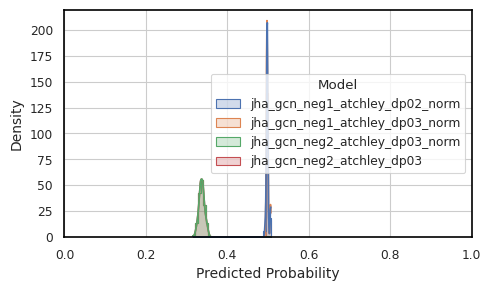

In [14]:
# plot probs distribution from raw_results.csv
import matplotlib.pyplot as plt
import pandas as pd
import os
import seaborn as sns

def plot_probability_distribution(results_dirs, pattern="_raw.csv", save_dir="."):
    """
    Plots the distribution of predicted probabilities for each model using seaborn.
    Args:
        results_dirs (list): List of directories containing results.
        pattern (str): File pattern to match.
        save_dir (str): Directory to save the plot.
    """
    all_probs = []
    for dir in results_dirs:
        for file in os.listdir(dir):
            if file.endswith(pattern):
                raw_results_path = os.path.join(dir, file)
                if not os.path.exists(raw_results_path):
                    print(f"File {raw_results_path} does not exist. Skipping.")
                    continue
                results_df = pd.read_csv(raw_results_path)
                for _, row in results_df.iterrows():
                    all_probs.append({
                        'Model': os.path.basename(dir),
                        'Probability': row['predictions']
                    })

    probs_df = pd.DataFrame(all_probs)

    # --- Style ---
    sns.set_theme(context='paper', style='whitegrid')
    sns.set_palette('deep')

    #plt.figure(figsize=(5, 3))  # single-column figure (NeurIPS size)
    fig, ax = plt.subplots(figsize=(5, 3))

    # --- Histogram plot ---
    sns.histplot(
        data=probs_df,
        x='Probability',
        hue='Model',
        kde=True,
        bins=30,
        element='step',
        stat='density',
        common_norm=False
    )

    plt.ylabel('Density', fontsize=10)
    plt.xlabel('Predicted Probability', fontsize=10)
    plt.xlim(0, 1.0)

    # increase linewidth of axes and make them black
    for spine in ax.spines.values():
        spine.set_linewidth(1.2)
        spine.set_color('black')

    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, "probability_distribution_histogram.png"))
    plt.show()

# Example usage
results_dirs = ["jha_gcn_neg1_atchley_dp02_norm",
                "jha_gcn_neg1_atchley_dp03_norm",
                "jha_gcn_neg2_atchley_dp03_norm",
                "jha_gcn_neg2_atchley_dp03"
                ]

plot_probability_distribution(results_dirs, pattern="_raw.csv", save_dir=".")
